In [48]:
from google.cloud import bigquery
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D
import upsetplot
from sankeyflow import Sankey

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [3]:
client = bigquery.Client(project='subugoe-collaborative')

In [5]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [6]:
openalex = 'subugoe-collaborative.openalex'
s2 = 'subugoe-wag-closed.S2AG'
pm = 'subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022'
cr = 'subugoe-collaborative.cr_instant.snapshot'

In [7]:
openalex_type_mapping = {
    'journal': {
        'editorial_discourse': ['erratum', 'editorial', 'letter', 'paratext'],
        'research_discourse': ['article']
    }
}

In [8]:
oal_type_mapping_kb = {
    'article': ['article', 'journal-volume', 'journal-article', 'journal-issue', 'journal', 'proceedings', 'posted-content', 'proceedings-series', 'proceedings-article'],
    'paratext': ['paratext'],
    'reference-entry': ['reference-entry'],
    'other': ['other'],
    'editorial': ['editorial'],
    'erratum': ['erratum'],
    'letter': ['letter'],
    'book-chapter' : ['book-chapter', 'book-part'],
    'book': ['book', 'book-series', 'monograph'],
    'dataset': ['dataset'],
    'dissertation': ['dissertation'],
    'report': ['report'],
    'peer-review': ['peer-review'],
    'grant': ['grant'],
    'standard': ['standard'],
    'other': ['other']
}

In [9]:
s2_type_mapping = {
    'journal': {
        'editorial_discourse': ['Editorial', 'News', 'LettersAndComments'],
        'research_discourse': ['Review', 'MetaAnalysis', 'JournalArticle', 'Study', 'CaseReport', 'ClinicalTrial']
    }
}

In [108]:
pubmed_type_mapping = {
    'journal': {
        'editorial_discourse': ['Published Erratum', 'Retraction of Publication', 'Retracted Publication', 'Editorial', 'News', 'Letter', 'Comment',
                                'Introductory Journal Article', 'Newspaper Article'],
        'research_discourse': ['Cochrane Systematic Review', 'Systematic Review', 'Meta-Analysis', 'Review', 'Case Reports', 'Randomized Controlled Trial', 'Clinical Trial', 
                               'Clinical Trial, Phase II', 'Clinical Trial, Phase III', 'Clinical Trial, Phase I', 
                               'Clinical Trial, Phase IV', 'Controlled Clinical Trial', 'Pragmatic Clinical Trial', 'Journal Article', 'Comparative Study', 'Multicenter Study', 
                               'Observational Study', 'Evaluation Study', 'Historical Article', 'Validation Study', 'Clinical Study', 'Randomized Controlled Trial, Veterinary',
                               'Twin Study', 'Clinical Trial, Veterinary', 'Classical Article', 'Observational Study, Veterinary', 'Corrected and Republished Article', 
                               'Adaptive Clinical Trial', 'Evaluation Studies', 'Validation Studies']
    }
}

In [11]:
crossref_type_mapping = {
    'journal': {
        'editorial_discourse': [],
        'research_discourse': ['journal-article']
    }
}

In [12]:
scp_type_mapping = {
    'journal': {
        'editorial_discourse': ['Erratum', 'Editorial', 'Letter', 'Note'],
        'research_discourse': ['Review', 'Article']
    }
}

In [13]:
wos_type_mapping = {
    'journal': {
        'editorial_discourse': ['Correction', 'Retraction', 'Retracted Publication', 'Item Withdrawal', 'Editorial Material', 'News Item', 'Letter'],
        'research_discourse': ['Review', 'Article']
    }
}

In [14]:
def mapping_types(mapping_dict, type):
    for k, v in mapping_dict.items():
        if type in v:
            return k

In [15]:
def alluvial_plot(df, db1_column_name, db2_column_name, db1_name, db2_name, image_name, width, height):
    df.fillna('None', inplace=True)
    d = {}
    for row in df.to_dict('records'):
        db1_type = row[db1_column_name] + ' (' + db1_name + ')'
        db2_type = row[db2_column_name] + ' (' + db2_name + ')'
        n = row['n']
    
        dd = {}
        dd[db2_type] = n
        
        if db1_type in d:
            d[db1_type].update(dd)
        else:
            d[db1_type] = dd

    d = {k + ' ': v for k, v in d.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    #fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [16]:
def alluvial_plot_new_types(df, db1_column_name, db2_column_name, db1_name, db2_name, db1_mapping, db2_mapping, image_name, width, height):
    df2 = df.copy()
    df2['db1_new_type'] = df2.apply(lambda row : mapping_types(db1_mapping, row[db1_column_name]), axis=1)
    df2['db2_new_type'] = df2.apply(lambda row : mapping_types(db2_mapping, row[db2_column_name]), axis=1)

    df2.fillna('None', inplace=True)

    d = {}
    for row in df2.to_dict('records'):
        db1_type = row['db1_new_type'] + ' (' + db1_name + ')'
        db2_type = row['db2_new_type'] + ' (' + db2_name + ')'
        current_r = row['db1_new_type'] + ' (' + db1_name + ')'
        n = row['n']
    
        if current_r in d:
            if db2_type in d[db1_type].keys():
                d[db1_type][db2_type] = d.get(db1_type).get(db2_type) + n
            else:
                 d[db1_type][db2_type] = n
        else:
            dd = {}
            dd[db2_type] = n
            d[db1_type] = dd

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    #fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [17]:
def plot_coverage(df, db1_column_name, db2_column_name, db1_mapping, db2_mapping, image_name, width, height):
    df2 = df.copy()
    df2.fillna('None', inplace=True)
    df2['db1_new_type'] = df2.apply(
                                lambda row : mapping_types(db1_mapping['journal'], 
                                                           row[db1_column_name]), axis=1)
    df2['db2_new_type'] = df2.apply(
                                lambda row : mapping_types(db2_mapping['journal'], 
                                                           row[db2_column_name]), axis=1)
    
    df2['type_match'] = (df2['db1_new_type']) == (df2['db2_new_type'])
    df2['type_match'] = df2['type_match'].astype(int)
    
    df_sum = df2[df2.type_match == 1].groupby(['journal', 'db1_new_type'])['n'].sum().reset_index().rename(columns={'n': '1_sum'})
    df_total = df2.groupby(['journal', 'db1_new_type'])['n'].sum().reset_index().rename(columns={'n': 'n_sum'})
    df_plot = pd.merge(df_sum, df_total, on=['journal', 'db1_new_type'])
    df_plot['prop'] = df_plot['1_sum'] / df_plot['n_sum']

    fig, ax = plt.subplots(figsize=(4.5, 4))

    plt.box(False)
    
    sns.stripplot(
        data=df_plot, 
        x='prop', 
        y='db1_new_type',
        marker='.',
        alpha=.1,
        edgecolor='#000000',
        color='#666666'
    )
    
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.tight_layout()
    plt.show()

In [18]:
openalex_types = client.query(f"""
                               SELECT type AS oal_type, COUNT(DISTINCT(doi)) AS n
                               FROM {openalex}.works  
                               WHERE publication_year between 2012 AND 2022
                               GROUP BY oal_type
                               ORDER BY n DESC
                               """).to_dataframe()

In [19]:
openalex_types

,oal_type,n
0,article,51957036
1,book-chapter,10357073
2,dataset,2373818
3,paratext,1484004
4,book,872256
5,other,726936
6,dissertation,715305
7,reference-entry,368314
8,peer-review,340128
9,standard,301296


In [20]:
openalex_venues = client.query(f"""
                                SELECT s.type AS venuetype, COUNT(DISTINCT(doi)) AS n
                                FROM {openalex}.works AS w
                                LEFT JOIN {openalex}.sources AS s
                                ON primary_location.source.id = s.id
                                WHERE publication_year between 2012 AND 2022
                                GROUP BY venuetype
                                ORDER BY n DESC
                                """).to_dataframe()

In [21]:
openalex_venues

,venuetype,n
0,journal,45888546
1,ebook platform,9021271
2,None,7824471
3,repository,4535878
4,book series,1759645
5,conference,922328
6,other,191


In [22]:
openalex_doctypes_venues = client.query(f"""
                                         SELECT w.type AS doctype, s.type AS venuetype, COUNT(DISTINCT(doi)) AS n
                                         FROM {openalex}.works AS w
                                         LEFT JOIN {openalex}.sources AS s
                                         ON primary_location.source.id = s.id
                                         WHERE publication_year between 2012 AND 2022
                                         GROUP BY venuetype, doctype
                                         ORDER BY venuetype, doctype
                                         """).to_dataframe()

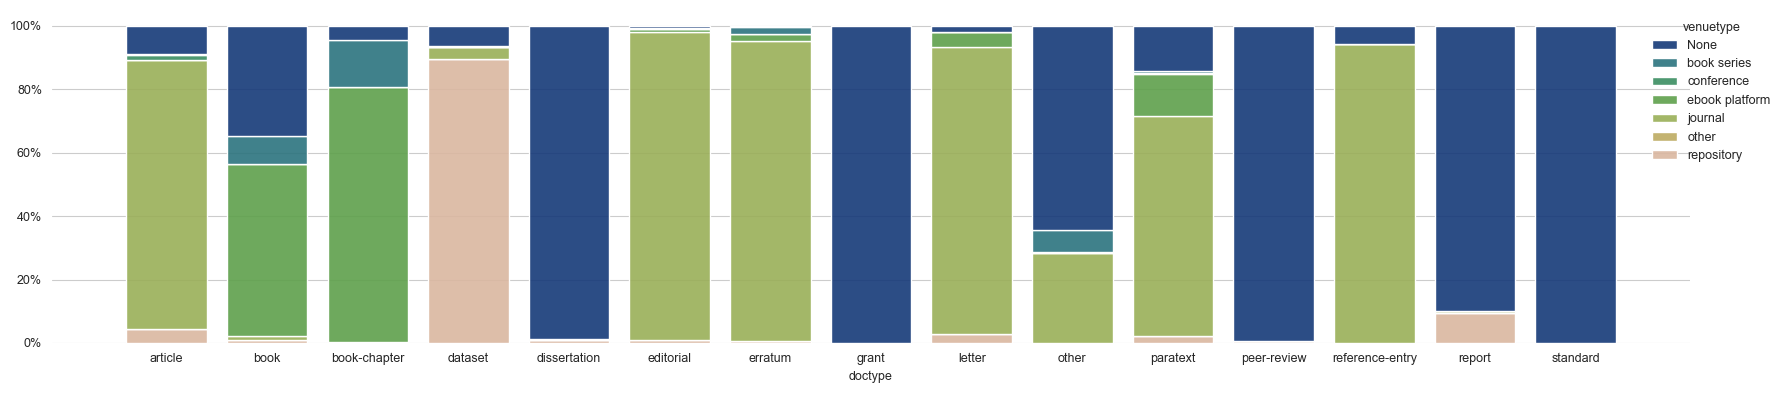

In [23]:
openalex_doctypes_venues['venuetype'].fillna('None', inplace=True)

openalex_doctypes_venues_plot = pd.merge(openalex_doctypes_venues, openalex_doctypes, on='doctype', how='inner', suffixes=[None, '_total'])
openalex_doctypes_venues_plot['prop'] = openalex_doctypes_venues_plot['n'] / openalex_doctypes_venues_plot['n_total']

fig, ax = plt.subplots(figsize=(18, 4))

plt.box(False)

cmap = colormaps['gist_earth']

ax = sns.histplot(
    openalex_doctypes_venues_plot,
    x='doctype',
    weights='prop',
    hue='venuetype',
    multiple='stack',
    palette='gist_earth',
    shrink=0.8,
    alpha=0.9
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('')

ax.xaxis.grid(False)

sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.97, 1), frameon=False)

plt.tight_layout()
plt.show()

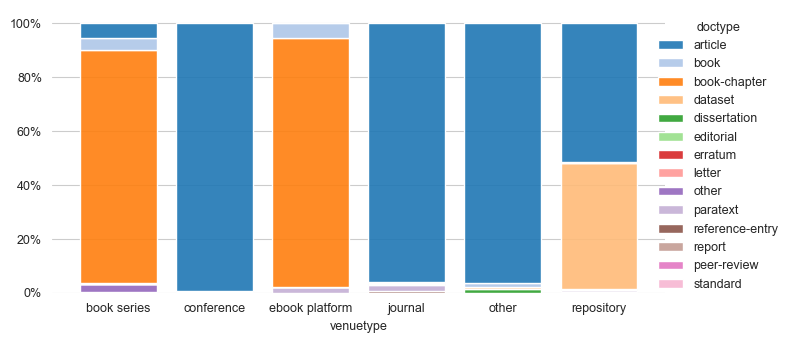

In [24]:
openalex_doctypes_venues['venuetype'].fillna('None', inplace=True)

openalex_doctypes_venues_plot = pd.merge(openalex_doctypes_venues, openalex_venues, on='venuetype', how='inner', suffixes=[None, '_total'])
openalex_doctypes_venues_plot['prop'] = openalex_doctypes_venues_plot['n'] / openalex_doctypes_venues_plot['n_total']

fig, ax = plt.subplots(figsize=(8, 3.5))

plt.box(False)

cmap = colormaps['gist_earth']

ax = sns.histplot(
    openalex_doctypes_venues_plot,
    x='venuetype',
    weights='prop',
    hue='doctype',
    multiple='stack',
    palette='tab20',
    shrink=0.8,
    alpha=0.9
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('')

ax.xaxis.grid(False)

sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.97, 1), frameon=False)

plt.tight_layout()
plt.show()

In [25]:
openalex_doctypes_venues[openalex_doctypes_venues.venuetype == 'journal']

,doctype,venuetype,n
50,article,journal,44012387
51,book,journal,9262
52,book-chapter,journal,17105
53,dataset,journal,86747
54,dissertation,journal,996
55,editorial,journal,101479
56,erratum,journal,61707
57,letter,journal,15239
58,other,journal,205240
59,paratext,journal,1029985


In [26]:
openalex_doctypes_venues_j = openalex_doctypes_venues[openalex_doctypes_venues.venuetype == 'journal'].copy()
openalex_doctypes_venues_j['oal_new_type'] = openalex_doctypes_venues_j.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['doctype']), axis=1)

In [27]:
openalex_doctypes_venues_j

,doctype,venuetype,n,oal_new_type
50,article,journal,44012387,research_discourse
51,book,journal,9262,None
52,book-chapter,journal,17105,None
53,dataset,journal,86747,None
54,dissertation,journal,996,research_discourse
55,editorial,journal,101479,editorial_discourses
56,erratum,journal,61707,editorial_discourses
57,letter,journal,15239,editorial_discourses
58,other,journal,205240,None
59,paratext,journal,1029985,editorial_discourses


In [28]:
s2_doctypes = client.query(f"""
                            SELECT s2_pubtypes as s2_doctype, COUNT(DISTINCT(externalids.DOI)) AS n
                            FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                            WHERE year between 2012 AND 2022
                            GROUP BY s2_pubtypes
                            ORDER BY n DESC
                            """).to_dataframe()

In [29]:
s2_doctypes

,s2_doctype,n
0,JournalArticle,15559120
1,Review,5667391
2,Conference,2256584
3,LettersAndComments,561803
4,CaseReport,537511
5,Study,494069
6,Editorial,306807
7,Book,250977
8,ClinicalTrial,83332
9,MetaAnalysis,69474


In [30]:
s2_venues = client.query(f"""
                          SELECT s.type AS venuetype, COUNT(DISTINCT(externalids.DOI)) AS n
                          FROM {s2}.papers_2023_09_26 AS w
                          LEFT JOIN {s2}.venues_2023_09_26 AS s
                          ON publicationvenueid = s.id
                          WHERE year between 2012 AND 2022
                          GROUP BY venuetype
                          ORDER BY n DESC
                          """).to_dataframe()

In [31]:
s2_venues

,venuetype,n
0,None,32045466
1,journal,22276524
2,conference,2261689


In [32]:
s2_doctypes_venues = client.query(f"""
                                  SELECT s2_pubtypes as s2_doctype, s.type AS venuetype, COUNT(DISTINCT(externalids.DOI)) AS n
                                  FROM {s2}.papers_2023_09_26 AS w, UNNEST(publicationtypes) AS s2_pubtypes
                                  LEFT JOIN {s2}.venues_2023_09_26 AS s
                                  ON publicationvenueid = s.id
                                  WHERE year between 2012 AND 2022
                                  GROUP BY venuetype, s2_doctype
                                  ORDER BY venuetype, s2_doctype
                                  """).to_dataframe()

In [33]:
s2_doctypes_venues[s2_doctypes_venues.venuetype == 'journal']

,s2_doctype,venuetype,n
24,Book,journal,2639
25,CaseReport,journal,476568
26,ClinicalTrial,journal,78147
27,Conference,journal,22373
28,Dataset,journal,548
29,Editorial,journal,274019
30,JournalArticle,journal,12040390
31,LettersAndComments,journal,524935
32,MetaAnalysis,journal,65678
33,News,journal,54973


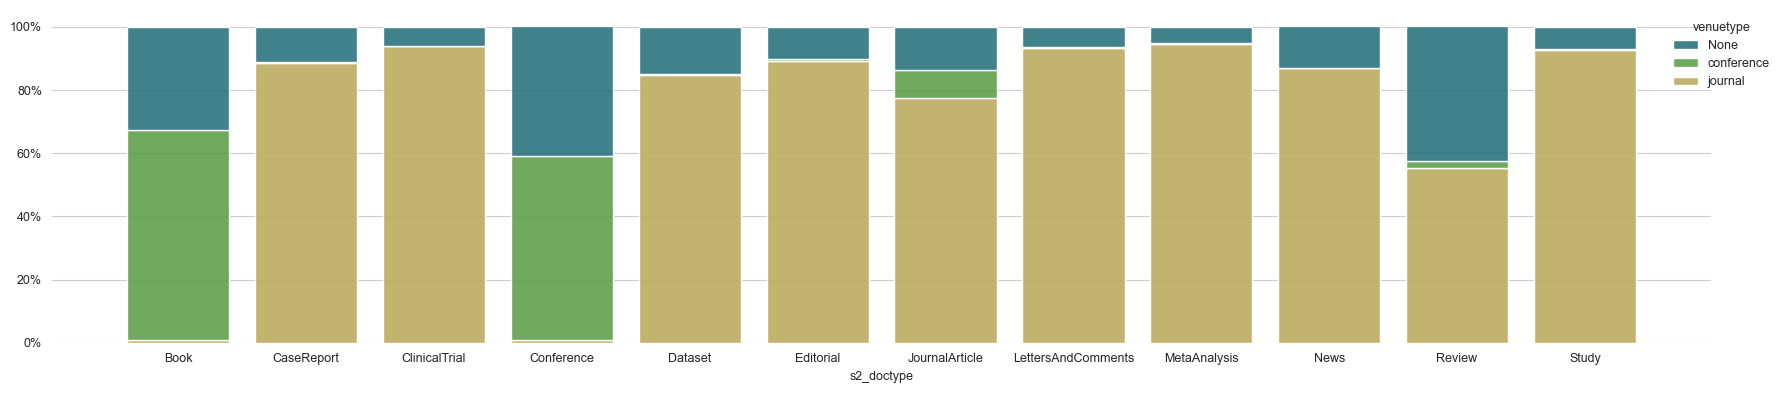

In [34]:
s2_doctypes_venues['venuetype'].fillna('None', inplace=True)

s2_doctypes_venues_plot = pd.merge(s2_doctypes_venues, s2_doctypes, on='s2_doctype', how='inner', suffixes=[None, '_total'])
s2_doctypes_venues_plot['prop'] = s2_doctypes_venues_plot['n'] / s2_doctypes_venues_plot['n_total']

fig, ax = plt.subplots(figsize=(18, 4))

plt.box(False)

cmap = colormaps['gist_earth']

ax = sns.histplot(
    s2_doctypes_venues_plot,
    x='s2_doctype',
    weights='prop',
    hue='venuetype',
    multiple='stack',
    palette='gist_earth',
    shrink=0.8,
    alpha=0.9
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('')

ax.xaxis.grid(False)

sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.97, 1), frameon=False)

plt.tight_layout()
plt.show()

In [35]:
s2_doctypes_venues_j = s2_doctypes_venues[s2_doctypes_venues.venuetype == 'journal'].copy()
s2_doctypes_venues_j['s2_new_type'] = s2_doctypes_venues_j.apply(lambda row : mapping_types(s2_type_mapping['journal'], row['s2_doctype']), axis=1)

In [36]:
s2_doctypes_venues_j

,s2_doctype,venuetype,n,s2_new_type
24,Book,journal,2639,None
25,CaseReport,journal,476568,research_discourse
26,ClinicalTrial,journal,78147,research_discourse
27,Conference,journal,22373,None
28,Dataset,journal,548,None
29,Editorial,journal,274019,editorial_discourses
30,JournalArticle,journal,12040390,research_discourse
31,LettersAndComments,journal,524935,editorial_discourses
32,MetaAnalysis,journal,65678,research_discourse
33,News,journal,54973,editorial_discourses


In [37]:
s2_oal_doctypes = client.query(f"""
                                SELECT oal.type AS oal_doctype, s2_pubtypes as s2_doctype, 
                                       s2_sources.type AS s2_venuetype,
                                       oal_sources.type AS oal_venuetype,
                                       COUNT(DISTINCT(oal.doi)) AS n
                                FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                                JOIN {openalex}.works AS oal
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                                    ON publicationvenueid =  s2_sources.id
                                LEFT JOIN {openalex}.sources AS oal_sources
                                    ON primary_location.source.id = oal_sources.id
                                WHERE publication_year between 2012 AND 2022
                                GROUP BY oal_doctype, s2_doctype, s2_venuetype, oal_venuetype
                                HAVING s2_venuetype = 'journal' AND oal_venuetype = 'journal'
                                ORDER BY oal_doctype, s2_doctype
                                """).to_dataframe()

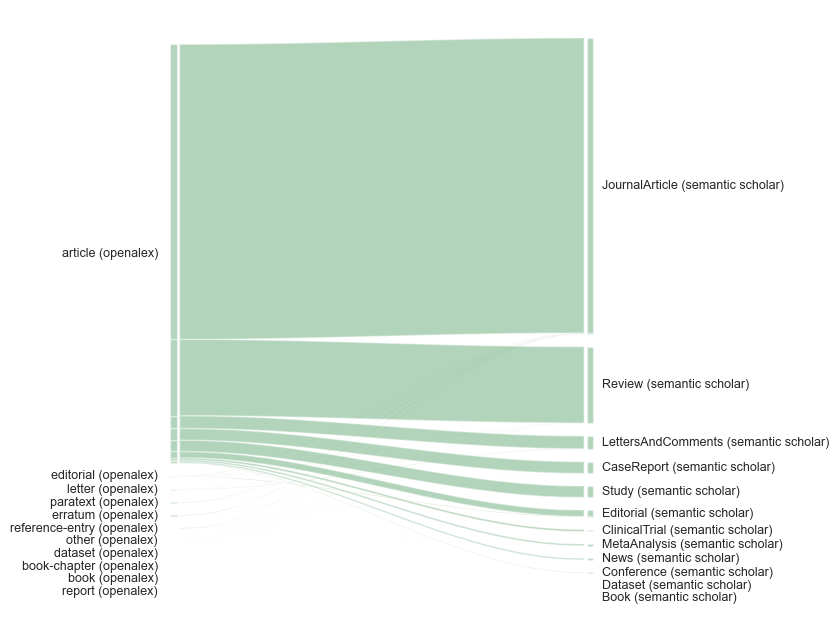

In [38]:
alluvial_plot(s2_oal_doctypes, 'oal_doctype', 's2_doctype', 'openalex', 'semantic scholar', 'openalex_s2', 6, 8)

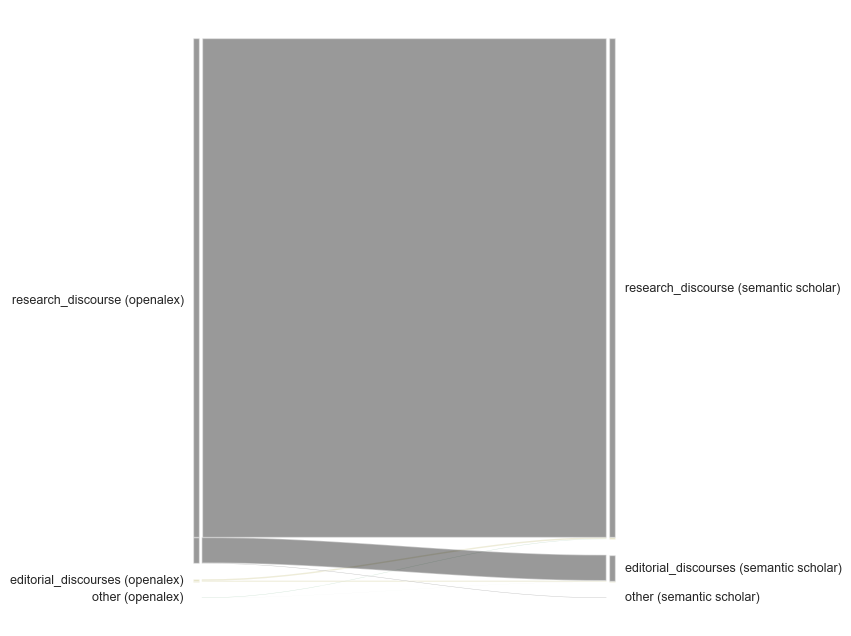

In [39]:
alluvial_plot_new_types(s2_oal_doctypes, 'oal_doctype', 's2_doctype', 'openalex', 'semantic scholar', 
                        openalex_type_mapping['journal'], s2_type_mapping['journal'], 'openalex_s2_new_clas', 6, 8)

In [40]:
s2_oal_venues = client.query(f"""
                              SELECT s2_sources.type AS s2_venuetype,
                                     oal_sources.type AS oal_venuetype,
                                     COUNT(DISTINCT(oal.doi)) AS n
                              FROM {s2}.papers_2023_09_26 AS s2
                              JOIN {openalex}.works AS oal
                                  ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                              LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                                  ON publicationvenueid =  s2_sources.id
                              LEFT JOIN {openalex}.sources AS oal_sources
                                  ON primary_location.source.id = oal_sources.id
                              WHERE publication_year between 2012 AND 2022
                              GROUP BY s2_venuetype, oal_venuetype
                              ORDER BY s2_venuetype, oal_venuetype
                              """).to_dataframe()

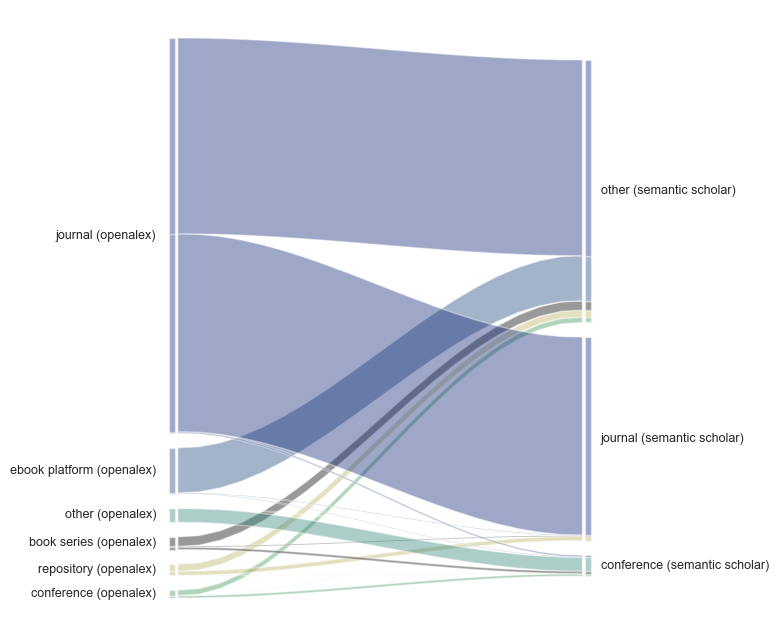

In [41]:
alluvial_plot(s2_oal_venues, 'oal_venuetype', 's2_venuetype', 'openalex', 'semantic scholar', 'openalex_s2_venues', 6, 8)

In [42]:
openalex_s2_doctypes_journal = client.query(f"""
                SELECT oal.type AS oal_doctype, s2_pubtypes as s2_doctype, 
                       s2_sources.type AS s2_venuetype,
                       oal_sources.type AS oal_venuetype,
                       primary_location.source.display_name AS journal,
                       COUNT(DISTINCT(oal.doi)) AS n
                FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                JOIN {openalex}.works AS oal
                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                    ON publicationvenueid =  s2_sources.id
                LEFT JOIN {openalex}.sources AS oal_sources
                    ON primary_location.source.id = oal_sources.id
                WHERE publication_year between 2012 AND 2022
                GROUP BY oal_doctype, s2_doctype, s2_venuetype, oal_venuetype, journal
                HAVING s2_venuetype = 'journal' AND oal_venuetype = 'journal'
                ORDER BY oal_doctype, s2_doctype
                """).to_dataframe()

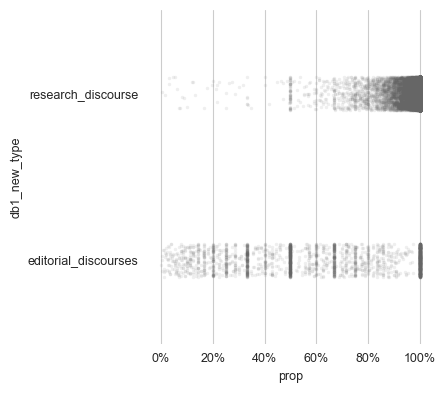

In [43]:
plot_coverage(openalex_s2_doctypes_journal, 'oal_doctype', 's2_doctype', openalex_type_mapping, s2_type_mapping, 'cov_oal_s2', 4.5, 4)

In [44]:
pm_doctypes = client.query(f"""
                            SELECT ptype AS pm_doctype, COUNT(DISTINCT(doi)) AS n
                            FROM {pm} AS pm
                            GROUP BY pm_doctype
                            ORDER BY n DESC
                            """).to_dataframe()

In [45]:
pm_doctypes

,pm_doctype,n
0,Journal Article,18041945
1,"Research Support, Non-U.S. Gov''t",5843529
2,Review,1970486
3,"Research Support, N.I.H., Extramural",1352844
4,Case Reports,1069817
...,...,...
74,Periodical Index,23
75,Legislation,21
76,None,15
77,Scientific Integrity Review,8


In [112]:
oal_pm_doctypes = client.query(f"""
                                SELECT oal_works.type AS oal_doctype, ptype AS pm_doctype, COUNT(DISTINCT(oal_works.doi)) AS n,
                                FROM {pm} AS pm
                                JOIN {openalex}.works AS oal_works
                                    ON LOWER(oal_works.doi) = LOWER(pm.doi)
                                LEFT JOIN {openalex}.sources AS oal_sources
                                    ON primary_location.source.id = oal_sources.id
                                WHERE publication_year between 2012 AND 2022 AND oal_sources.type = 'journal'
                                GROUP BY oal_doctype, pm_doctype
                                ORDER BY oal_doctype, pm_doctype
                                """).to_dataframe()

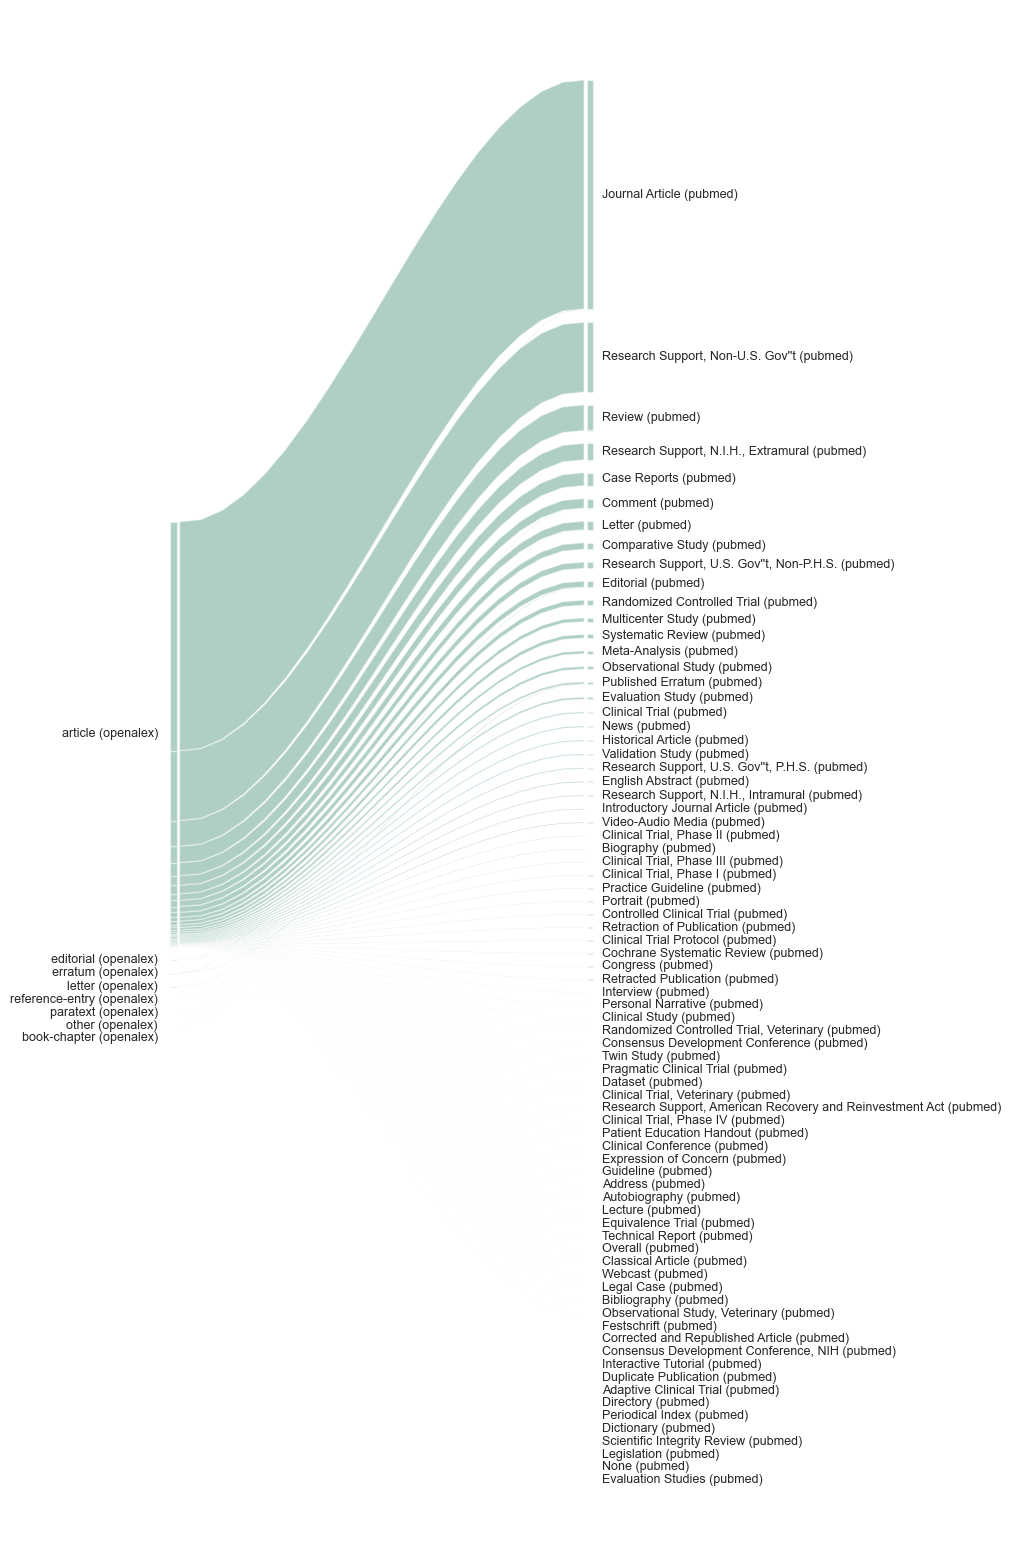

In [113]:
alluvial_plot(oal_pm_doctypes, 'oal_doctype', 'pm_doctype', 'openalex', 'pubmed', 'openalex_pubmed', 6, 20)

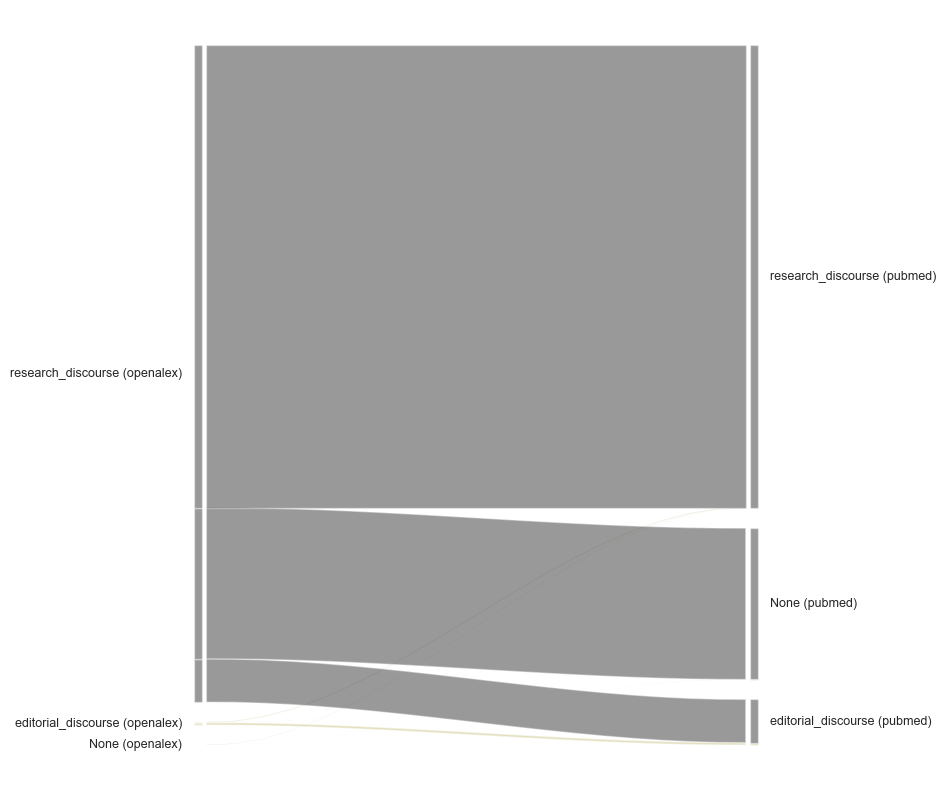

In [114]:
alluvial_plot_new_types(oal_pm_doctypes, 
                        'oal_doctype', 
                        'pm_doctype', 
                        'openalex', 
                        'pubmed', 
                        openalex_type_mapping['journal'], 
                        pubmed_type_mapping['journal'], 
                        'openalex_pubmed_new_clas', 
                        8, 
                        10)

In [115]:
openalex_pm_doctypes_journal = client.query(f"""
                SELECT oal_works.type AS oal_doctype, ptype AS pm_doctype, COUNT(DISTINCT(oal_works.doi)) AS n,
                    primary_location.source.display_name AS journal,
                FROM {pm} AS pm
                JOIN {openalex}.works AS oal_works
                    ON LOWER(oal_works.doi) = LOWER(pm.doi)
                LEFT JOIN {openalex}.sources AS oal_sources
                    ON primary_location.source.id = oal_sources.id
                WHERE publication_year between 2012 AND 2022 AND oal_sources.type = 'journal'
                GROUP BY oal_doctype, pm_doctype, journal
                ORDER BY oal_doctype, pm_doctype
                """).to_dataframe()

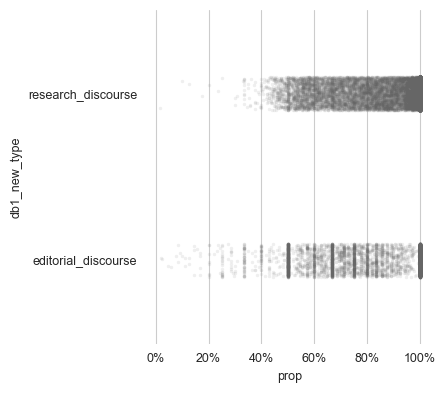

In [116]:
plot_coverage(openalex_pm_doctypes_journal, 'oal_doctype', 'pm_doctype', openalex_type_mapping, pubmed_type_mapping, 'cov_oal_pm', 4.5, 4)

## KB

In [63]:
oal_worktypes = pd.read_sql("""
                     SELECT type AS oal_worktype, COUNT(DISTINCT(doi)) AS n
                     FROM fiz_openalex_rep_20230819_openbib.works works
                     WHERE publication_year between 2012 AND 2022
                     GROUP BY oal_worktype
                     ORDER BY n DESC
                     """, 
                     con=engine)

In [82]:
oal_worktypes.style.hide(axis='index')

oal_worktype,n
article,51735983
book-chapter,10501738
dataset,2115309
paratext,1430186
book,877915
dissertation,714665
reference-entry,528947
other,474053
peer-review,337330
standard,301094


In [36]:
oal_venues = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, COUNT(DISTINCT(oal_works.doi)) AS number_of_dois
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype
                         ORDER BY number_of_dois DESC
                         """, 
                         con=engine)

In [37]:
oal_venues

,oal_venuetype,number_of_dois
0,journal,45221358
1,None,9830947
2,ebook platform,7974296
3,repository,4194457
4,book series,1413854
5,conference,822713
6,other,195


In [90]:
t = oal_venues.copy()
t['prop'] = (t['number_of_dois'] / t['number_of_dois'].sum()) * 100
t.style.hide(axis="index")

oal_venuetype,number_of_dois,prop
journal,45221358,65.106216
None,9830947,14.153838
ebook platform,7974296,11.480775
repository,4194457,6.038855
book series,1413854,2.035558
conference,822713,1.184479
other,195,0.000281


In [21]:
oal_doctypes_venues = pd.read_sql("""
                         SELECT oal_works.type AS oal_worktype, oal_sources.type AS oal_venuetype, COUNT(DISTINCT(oal_works.doi)) AS number_of_dois
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_worktype, oal_venuetype
                         ORDER BY number_of_dois DESC
                         """, 
                         con=engine)

In [89]:
t = oal_doctypes_venues[oal_doctypes_venues.oal_venuetype == 'journal'].copy()
t['prop'] = (t['number_of_dois'] / t['number_of_dois'].sum()) * 100
t.style.hide(axis="index")

oal_worktype,oal_venuetype,number_of_dois,prop
article,journal,43384203,95.937411
paratext,journal,992922,2.195692
reference-entry,journal,498743,1.102893
other,journal,133806,0.295891
editorial,journal,100140,0.221444
erratum,journal,61811,0.136685
letter,journal,15009,0.033190
book-chapter,journal,9366,0.020711
journal-volume,journal,7562,0.016722
book,journal,6545,0.014473


In [85]:
oal_doctypes_venues_j = oal_doctypes_venues[oal_doctypes_venues.oal_venuetype == 'journal'].copy()
oal_doctypes_venues_j['oal_worktype'] = oal_doctypes_venues_j.apply(lambda row : mapping_types(oal_type_mapping_kb, row['oal_worktype']), axis=1)
oal_doctypes_venues_j['oal_new_type'] = oal_doctypes_venues_j.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_worktype']), axis=1)
oal_doctypes_venues_j['oal_new_type'].fillna('None', inplace=True)
oal_doctypes_venues_j = oal_doctypes_venues_j.groupby(['oal_worktype', 'oal_venuetype', 'oal_new_type'])['number_of_dois'].sum().reset_index()
oal_doctypes_venues_j['prop'] = (oal_doctypes_venues_j['number_of_dois'] / oal_doctypes_venues_j['number_of_dois'].sum()) * 100
oal_doctypes_venues_j.sort_values(by=['prop'], ascending=False).reset_index(drop=True)

,oal_worktype,oal_venuetype,oal_new_type,number_of_dois,prop
0,article,journal,research_discourse,43394995,95.961276
1,paratext,journal,editorial_discourse,992922,2.195692
2,reference-entry,journal,None,498743,1.102893
3,other,journal,None,133806,0.295891
4,editorial,journal,editorial_discourse,100140,0.221444
5,erratum,journal,editorial_discourse,61811,0.136685
6,letter,journal,editorial_discourse,15009,0.033190
7,book-chapter,journal,None,9388,0.020760
8,book,journal,None,6755,0.014938
9,dataset,journal,None,5887,0.013018


In [51]:
scp_doctypes = pd.read_sql("""
                     SELECT unnest(item_type) AS scp_doctype, COUNT(DISTINCT(doi)) AS n
                     FROM scp_b_202307.items i
                     WHERE pubyear between 2012 AND 2022
                     GROUP BY scp_doctype
                     ORDER BY n DESC
                     """, 
                     con=engine)

In [52]:
scp_doctypes

,scp_doctype,n
0,Article,22084165
1,Conference Paper,4534453
2,Review,1870439
3,Chapter,1312300
4,Editorial,586313
5,Note,553473
6,Letter,500280
7,Erratum,243428
8,Book,167978
9,Short Survey,98545


In [53]:
scp_venues = pd.read_sql("""
                     SELECT source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                     FROM scp_b_202307.items i
                     WHERE pubyear between 2012 AND 2022
                     GROUP BY venuetype
                     ORDER BY n DESC
                     """, 
                     con=engine)

In [54]:
scp_venues

,venuetype,n
0,Journal,25910196
1,Conference Proceeding,3599438
2,Book Series,1231097
3,Book,1146001
4,Trade Journal,39325
5,None,8291
6,x,8
7,Multi-volume Reference Works,1


In [55]:
scp_doctypes_venues = pd.read_sql("""
                         SELECT unnest(item_type) AS scp_doctype, source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                         FROM scp_b_202307.items i
                         WHERE pubyear between 2012 AND 2022
                         GROUP BY venuetype, scp_doctype
                         ORDER BY n DESC
                         """, 
                         con=engine)

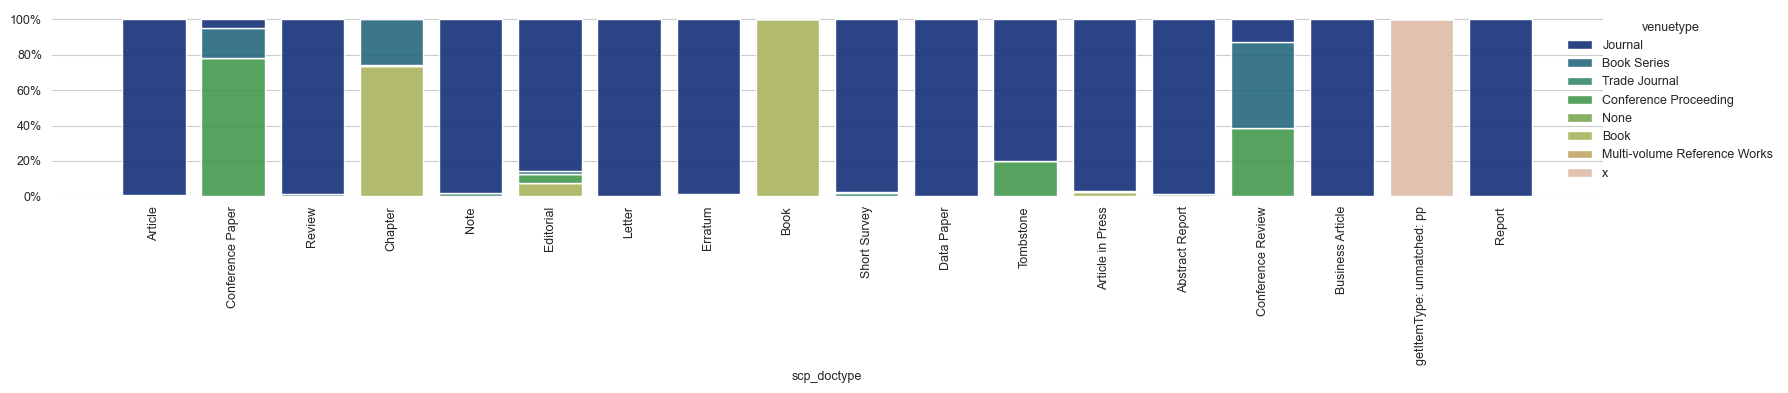

In [56]:
scp_doctypes_venues['venuetype'].fillna('None', inplace=True)

scp_doctypes_venues_plot = pd.merge(scp_doctypes_venues, scp_doctypes, on='scp_doctype', how='inner', suffixes=[None, '_total'])
scp_doctypes_venues_plot['prop'] = scp_doctypes_venues_plot['n'] / scp_doctypes_venues_plot['n_total']

fig, ax = plt.subplots(figsize=(18, 4))

plt.box(False)

cmap = colormaps['gist_earth']

ax = sns.histplot(
    scp_doctypes_venues_plot,
    x='scp_doctype',
    weights='prop',
    hue='venuetype',
    multiple='stack',
    palette='gist_earth',
    shrink=0.8,
    alpha=0.9
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('')
plt.xticks(rotation=90)

ax.xaxis.grid(False)

sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.97, 1), frameon=False)

plt.tight_layout()
plt.show()

In [57]:
scp_doctypes_venues[scp_doctypes_venues.venuetype == 'Journal']

,scp_doctype,venuetype,n
0,Article,Journal,21929328
2,Review,Journal,1849230
5,Note,Journal,542886
6,Editorial,Journal,503148
7,Letter,Journal,499791
9,Erratum,Journal,240901
10,Conference Paper,Journal,237241
13,Short Survey,Journal,96366
18,Data Paper,Journal,12341
20,Tombstone,Journal,9595


In [58]:
scp_doctypes_venues_j = scp_doctypes_venues[scp_doctypes_venues.venuetype == 'Journal'].copy()
scp_doctypes_venues_j['scp_new_type'] = scp_doctypes_venues_j.apply(lambda row : mapping_types(scp_type_mapping['journal'], row['scp_doctype']), axis=1)

In [59]:
scp_doctypes_venues_j

,scp_doctype,venuetype,n,scp_new_type
0,Article,Journal,21929328,research_discourse
2,Review,Journal,1849230,research_discourse
5,Note,Journal,542886,editorial_discourses
6,Editorial,Journal,503148,editorial_discourses
7,Letter,Journal,499791,editorial_discourses
9,Erratum,Journal,240901,editorial_discourses
10,Conference Paper,Journal,237241,None
13,Short Survey,Journal,96366,None
18,Data Paper,Journal,12341,None
20,Tombstone,Journal,9595,None


In [22]:
oal_scp_type = pd.read_sql("""
                         SELECT oal_works.type AS oal_type, unnest(item_type) AS scp_type, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND scp_items.source_type = 'Journal'
                         GROUP BY oal_type, scp_type
                         """, 
                         con=engine)

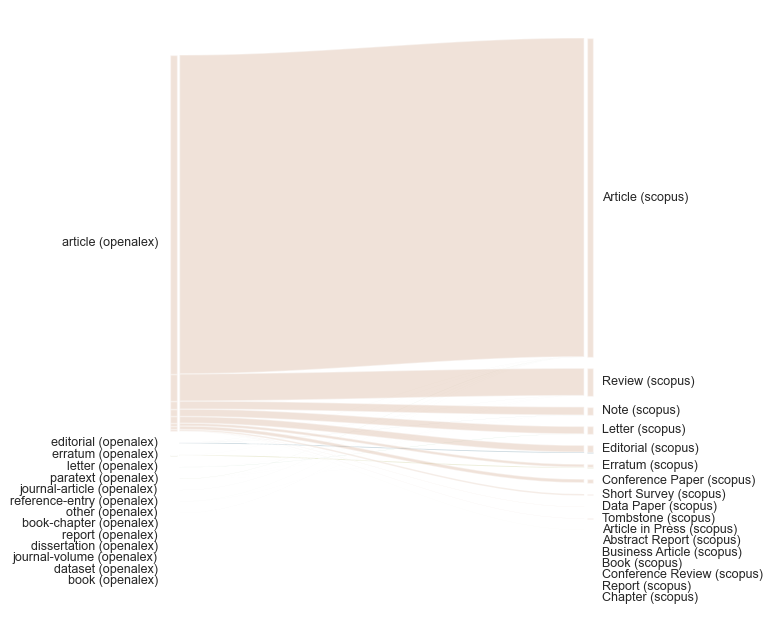

In [86]:
alluvial_plot(oal_scp_type, 'oal_type', 'scp_type', 'openalex', 'scopus', 'openalex_scp', 6, 8)

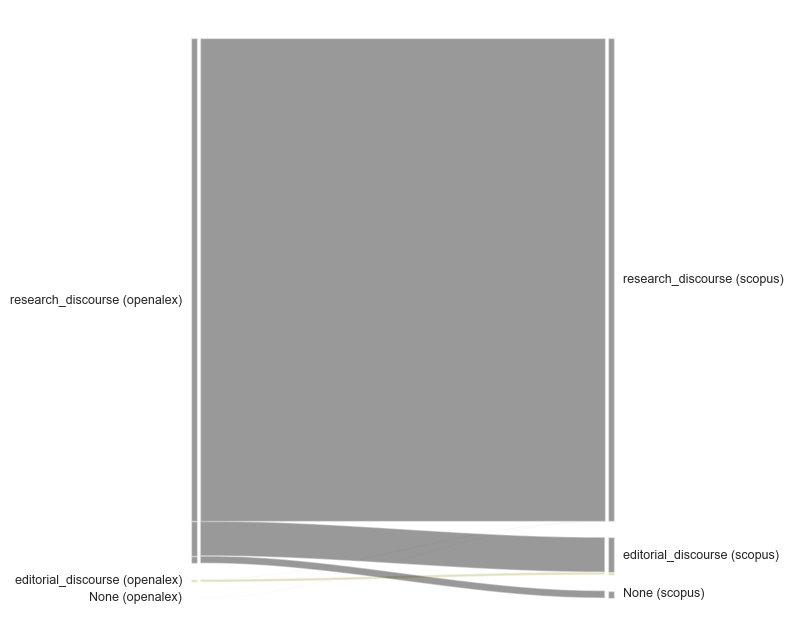

In [87]:
alluvial_plot_new_types(oal_scp_type, 'oal_type', 'scp_type', 'openalex', 'scopus', openalex_type_mapping['journal'], scp_type_mapping['journal'], 'openalex_scp_new_clas', 6, 8)

In [23]:
oal_scp_venue = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, scp_items.source_type AS scp_venuetype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, scp_venuetype
                         """, 
                         con=engine)

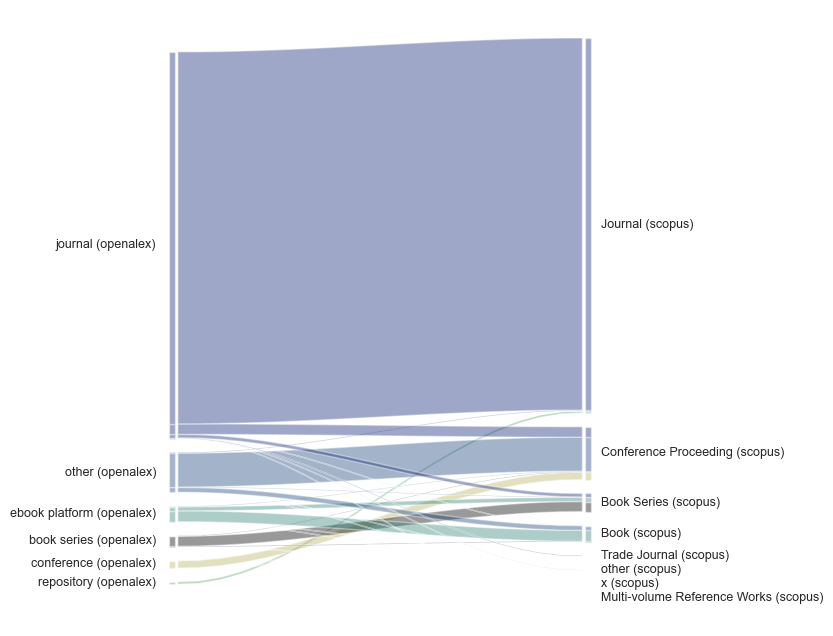

In [24]:
alluvial_plot(oal_scp_venue, 'oal_venuetype', 'scp_venuetype', 'openalex', 'scopus', 'openalex_scp_venues', 6, 8)

In [28]:
openalex_scp_types_journal = pd.read_sql(f"""
                SELECT oal_works.type AS oal_type, unnest(item_type) AS scp_type, COUNT(DISTINCT(oal_works.doi)) AS n,
                    oal_sources.display_name AS journal
                FROM fiz_openalex_rep_20230819_openbib.works oal_works
                JOIN scp_b_202307.items scp_items
                    ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                    ON oal_works.id = oal_primary.work_id
                JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                    ON oal_primary.source_id = oal_sources.id
                WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND scp_items.source_type = 'Journal'
                GROUP BY oal_type, scp_type, journal
                """, con=engine)

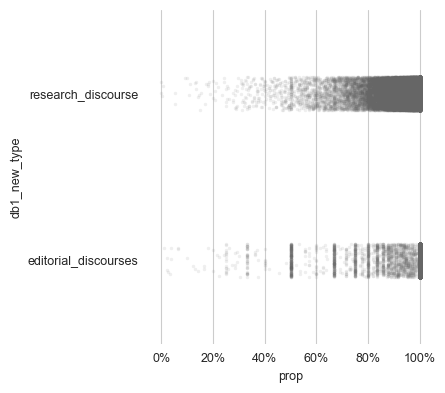

In [29]:
plot_coverage(openalex_scp_types_journal, 'oal_type', 'scp_type', openalex_type_mapping, scp_type_mapping, 'cov_oal_scp', 4.5, 4)

In [67]:
wos_doctype = pd.read_sql("""
                 SELECT unnest(item_type) AS wos_doctype, COUNT(DISTINCT(doi)) AS n
                 FROM wos_b_202307.v_items i
                 WHERE pubyear between 2012 AND 2022
                 GROUP BY wos_doctype
                 ORDER BY n DESC
                 """, 
                 con=engine)

In [68]:
wos_doctype

,wos_doctype,n
0,Article,17614311
1,Proceedings Paper,1920993
2,Review,1287517
3,Editorial Material,1007621
4,Meeting Abstract,876455
5,Letter,448972
6,Book Review,345988
7,Correction,197476
8,Early Access,144347
9,News Item,65320


In [69]:
wos_venues = pd.read_sql("""
                 SELECT source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                 FROM wos_b_202307.v_items i
                 WHERE pubyear between 2012 AND 2022
                 GROUP BY venuetype
                 ORDER BY n DESC
                 """, 
                 con=engine)

In [70]:
wos_venues

,venuetype,n
0,Journal,21913281
1,Book in series,1330254
2,Book,298048


In [71]:
wos_doctypes_venues = pd.read_sql("""
                         SELECT unnest(item_type) AS wos_doctype, source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                         FROM wos_b_202307.v_items i
                         WHERE pubyear between 2012 AND 2022
                         GROUP BY venuetype, wos_doctype
                         ORDER BY n DESC
                         """, 
                         con=engine)

In [72]:
wos_doctypes_venues[wos_doctypes_venues.venuetype == 'Journal']

,wos_doctype,venuetype,n
0,Article,Journal,17593155
2,Review,Journal,1262843
3,Editorial Material,Journal,1006883
4,Meeting Abstract,Journal,875978
5,Letter,Journal,448971
6,Book Review,Journal,345981
7,Proceedings Paper,Journal,336507
9,Correction,Journal,197383
10,Early Access,Journal,144347
11,News Item,Journal,65320


In [92]:
oal_wos_doctype = pd.read_sql("""
                         SELECT oal_works.type AS oal_doctype, unnest(item_type) AS wos_doctype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND wos_items.source_type = 'Journal'
                         GROUP BY oal_doctype, wos_doctype
                         """, 
                         con=engine)

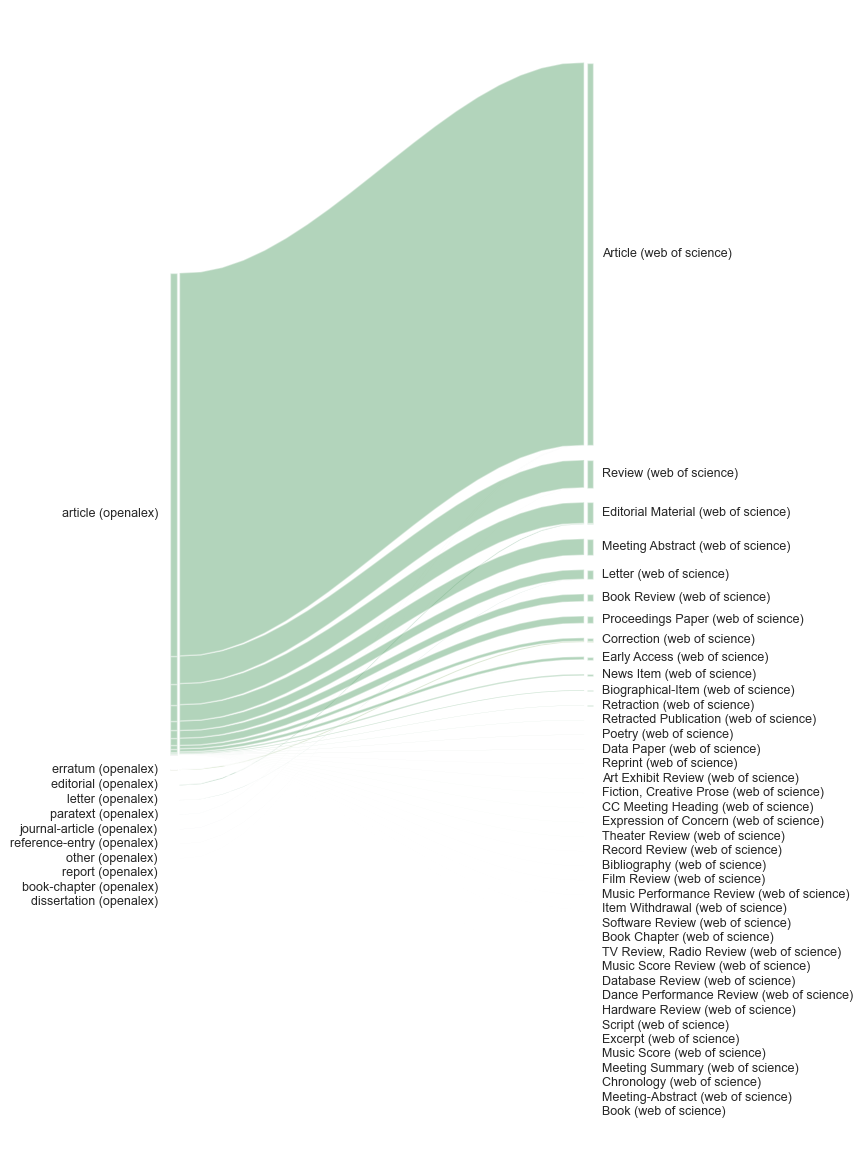

In [93]:
alluvial_plot(oal_wos_doctype, 'oal_doctype', 'wos_doctype', 'openalex', 'web of science', 'openalex_wos', 6, 15)

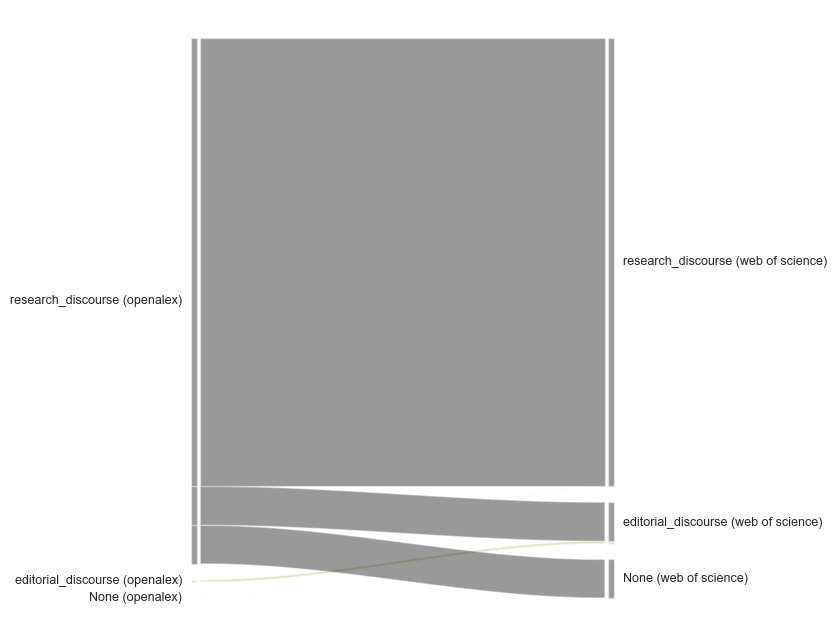

In [94]:
alluvial_plot_new_types(oal_wos_doctype, 'oal_doctype', 'wos_doctype', 'openalex', 'web of science', 
                        openalex_type_mapping['journal'], wos_type_mapping['journal'], 'openalex_wos_new_clas', 6, 8)

In [95]:
oal_wos_venue = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, wos_items.source_type AS wos_venuetype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, wos_venuetype
                         """, 
                         con=engine)

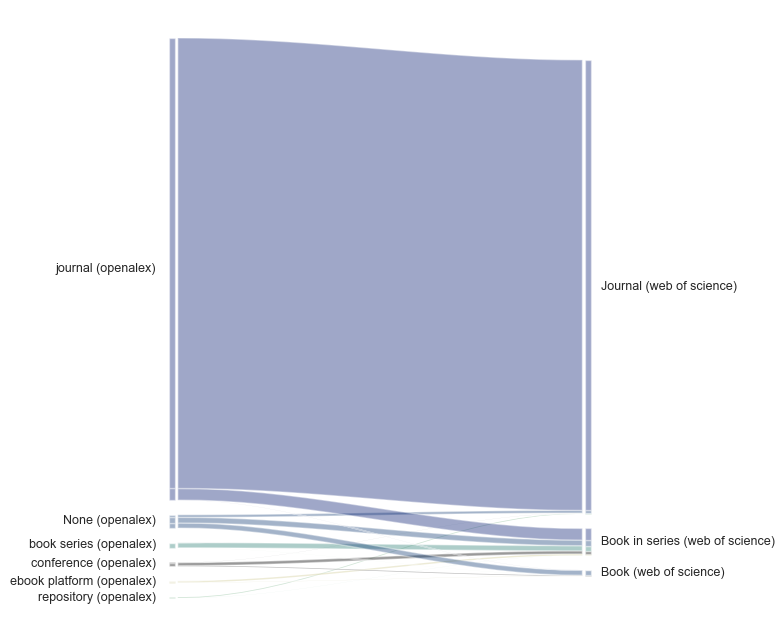

In [96]:
alluvial_plot(oal_wos_venue, 'oal_venuetype', 'wos_venuetype', 'openalex', 'web of science', 'openalex_wos_venues', 6, 8)

In [97]:
openalex_wos_doctypes_journal = pd.read_sql(f"""
                SELECT oal_works.type AS oal_doctype, unnest(item_type) AS wos_doctype, COUNT(DISTINCT(oal_works.doi)) AS n,
                    oal_sources.display_name AS journal
                FROM fiz_openalex_rep_20230819_openbib.works oal_works
                JOIN wos_b_202307.v_items wos_items
                    ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                    ON oal_works.id = oal_primary.work_id
                JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                    ON oal_primary.source_id = oal_sources.id
                WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND wos_items.source_type = 'Journal'
                GROUP BY oal_doctype, wos_doctype, journal
                """, con=engine)

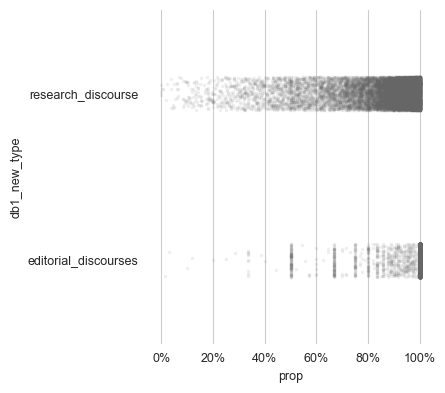

In [79]:
plot_coverage(openalex_wos_doctypes_journal, 'oal_doctype', 'wos_doctype', openalex_type_mapping, wos_type_mapping, 'cov_oal_wos', 4.5, 4)

In [80]:
cr_doctypes = pd.read_sql("""
                          SELECT type as cr_doctype, COUNT(DISTINCT(doi)) AS n
                          FROM open_add_ons.cr_oct2023
                          WHERE issued > '2011-12-31' AND issued < '2023-01-01'
                          GROUP BY cr_doctype
                          ORDER BY n DESC
                          """, 
                          con=engine)

In [81]:
cr_doctypes

,cr_doctype,n
0,journal-article,43087439
1,book-chapter,9505675
2,proceedings-article,4200610
3,dataset,1158873
4,posted-content,1059360
5,other,674813
6,journal-issue,573367
7,book,540114
8,component,489748
9,reference-entry,374666


In [101]:
oal_cr_worktype = pd.read_sql("""
                         SELECT oal_works.type AS oal_worktype, cr_items.type AS cr_worktype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN open_add_ons.cr_oct2023 cr_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(cr_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal'
                         GROUP BY oal_worktype, cr_worktype
                         """, 
                         con=engine)

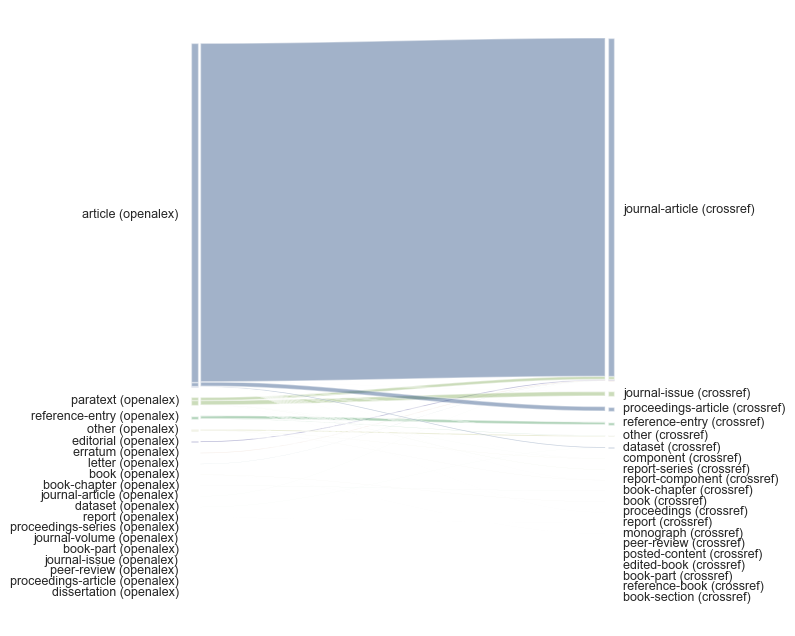

In [102]:
alluvial_plot(oal_cr_worktype, 'oal_worktype', 'cr_worktype', 'openalex', 'crossref', 'openalex_cr', 6, 8)

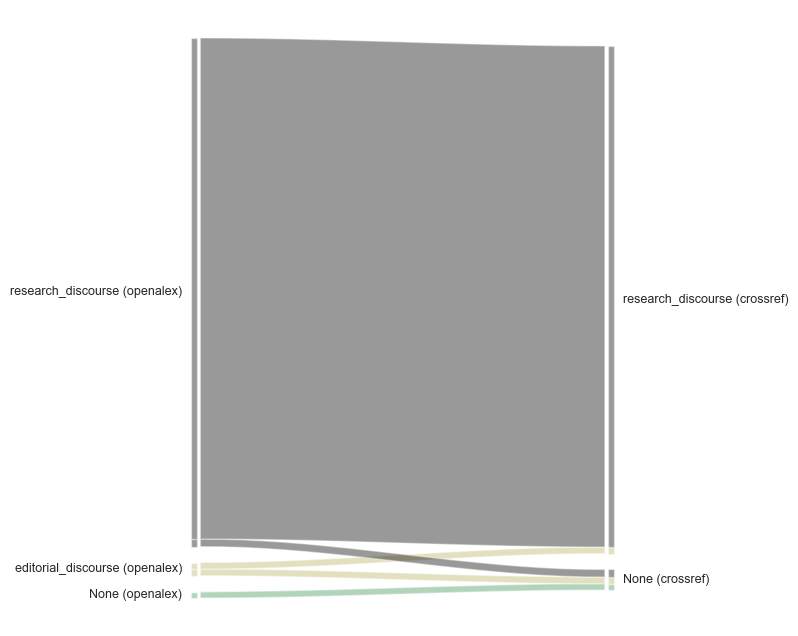

In [103]:
alluvial_plot_new_types(oal_cr_worktype, 'oal_worktype', 'cr_worktype', 'openalex', 'crossref', 
                        openalex_type_mapping['journal'], crossref_type_mapping['journal'], 'openalex_cr_new_clas', 6, 8)

In [98]:
openalex_cr_worktypes_journal = pd.read_sql(f"""
                SELECT oal_works.type AS oal_worktype, cr_items.type AS cr_worktype, COUNT(DISTINCT(oal_works.doi)) AS n,
                    oal_sources.display_name AS journal
                FROM fiz_openalex_rep_20230819_openbib.works oal_works
                JOIN open_add_ons.cr_oct2023 cr_items
                    ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(cr_items.doi)
                JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                    ON oal_works.id = oal_primary.work_id
                JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                    ON oal_primary.source_id = oal_sources.id
                WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal'
                GROUP BY oal_worktype, cr_worktype, journal
                """, con=engine)

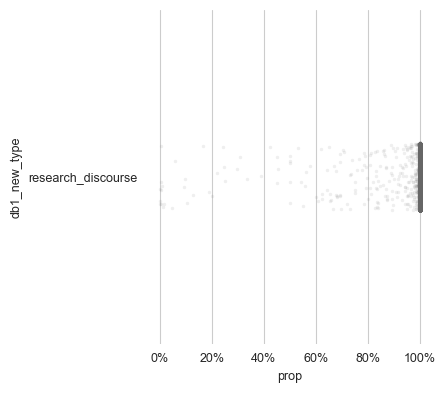

In [99]:
plot_coverage(openalex_cr_worktypes_journal, 'oal_worktype', 'cr_worktype', openalex_type_mapping, crossref_type_mapping, 'cov_oal_cr', 4.5, 4)

In [18]:
oal_wos_scp_worktype = pd.read_sql("""
                         SELECT oal_works.type AS oal_worktype, unnest(wos_items.item_type) AS wos_worktype, unnest(scp_items.item_type) AS scp_worktype,
                             COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND wos_items.source_type = 'Journal'
                             AND scp_items.source_type = 'Journal'
                         GROUP BY oal_worktype, scp_worktype, wos_worktype
                         """, 
                         con=engine)

In [19]:
oal_wos_scp_worktype

,oal_worktype,wos_worktype,scp_worktype,n
0,article,Article,Abstract Report,12
1,article,Editorial Material,Abstract Report,1
2,article,Art Exhibit Review,Article,258
3,article,Article,Article,16579687
4,article,Bibliography,Article,111
...,...,...,...,...
385,reference-entry,Review,Note,6
386,reference-entry,Correction,Review,7
387,reference-entry,Review,Review,502
388,report,Article,Article,1


In [20]:
oal_wos_scp_worktype['oal_new_type'] = oal_wos_scp_worktype.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_worktype']), axis=1)
oal_wos_scp_worktype['wos_new_type'] = oal_wos_scp_worktype.apply(lambda row : mapping_types(wos_type_mapping['journal'], row['wos_worktype']), axis=1)
oal_wos_scp_worktype['scp_new_type'] = oal_wos_scp_worktype.apply(lambda row : mapping_types(scp_type_mapping['journal'], row['scp_worktype']), axis=1)

In [21]:
oal_wos_scp_worktype['oal_new_type'] = oal_wos_scp_worktype.apply(lambda row : str(row['oal_new_type']) + ' (oal)', axis=1)
oal_wos_scp_worktype['wos_new_type'] = oal_wos_scp_worktype.apply(lambda row : str(row['wos_new_type']) + ' (wos)', axis=1)
oal_wos_scp_worktype['scp_new_type'] = oal_wos_scp_worktype.apply(lambda row : str(row['scp_new_type']) + ' (scp)', axis=1)

In [22]:
oal_wos_scp_worktype['intersection'] = oal_wos_scp_worktype.apply(lambda row : str(row['oal_new_type'])+','+str(row['wos_new_type'])+','+str(row['scp_new_type']), axis=1)

In [23]:
upset_df = oal_wos_scp_worktype.groupby(['intersection'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

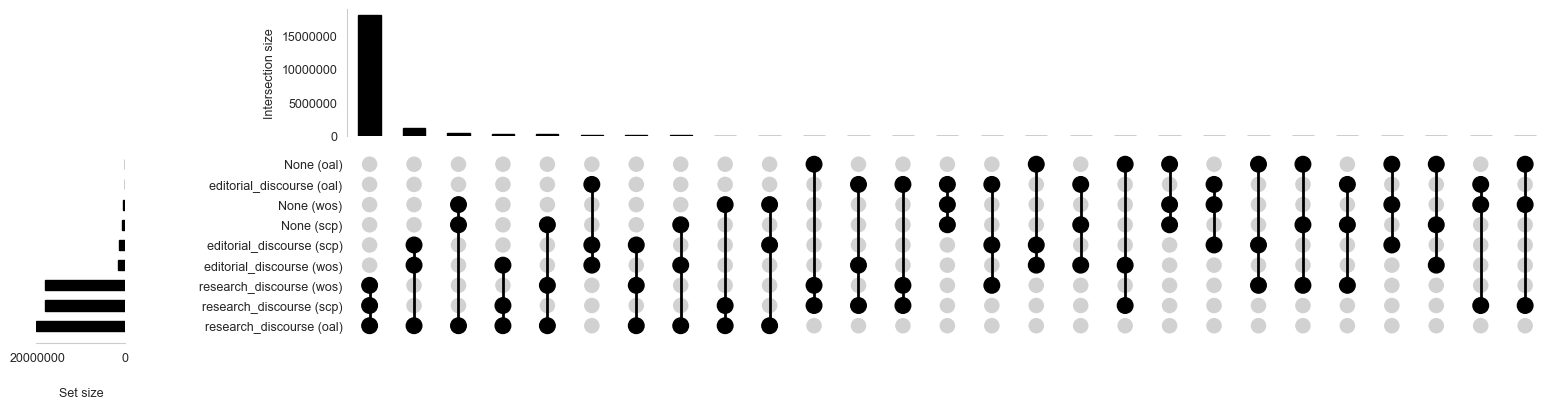

In [24]:
fig = plt.figure(figsize=(8,5))

cat_list = upset_df.intersection.tolist()
cat_list = [cat.split(',') for cat in cat_list]
n_list = upset_df.n.tolist()


upset_expr = upsetplot.from_memberships(cat_list, 
                                        data=n_list)

axes = upsetplot.UpSet(
    upset_expr,
    sort_by='cardinality',
    subset_size='sum',
    sort_categories_by='cardinality').plot(fig=fig)

axes['intersections'].yaxis.grid(False)

axes['totals'].xaxis.grid(False)

axes['intersections'].ticklabel_format(style='plain', axis='y')

axes['totals'].ticklabel_format(style='plain', axis='x')

plt.subplots_adjust(left=0, bottom=0, right=1, top=0.5, wspace=0, hspace=0)

fig.text(0.03, -0.08, 'Set size', ha='center', 
         fontdict={'fontsize': 9, 'fontweight': 500})

fig.delaxes(axes['shading'])
    
plt.show()

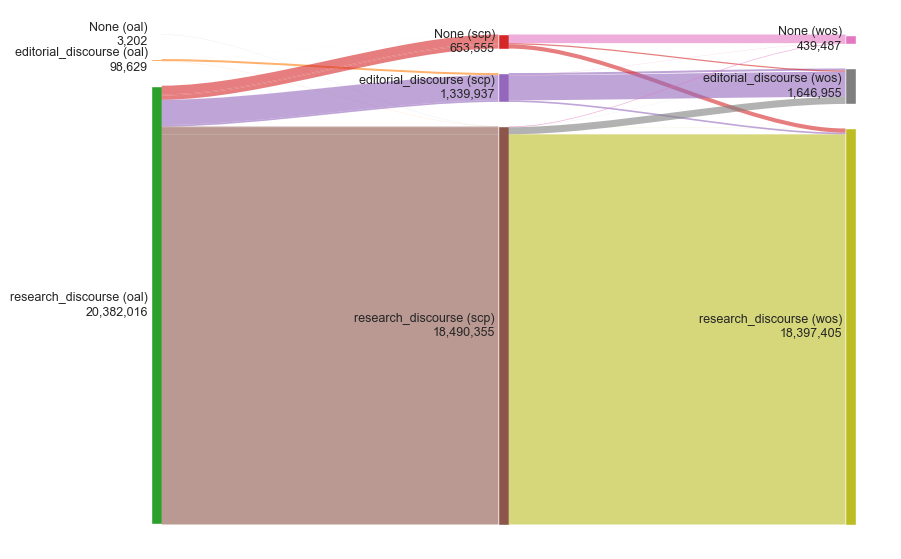

In [93]:
flows_df = oal_wos_scp_worktype[['oal_new_type', 'scp_new_type', 'wos_new_type', 'n']]
flows_df = flows_df.groupby(['oal_new_type', 'scp_new_type', 'wos_new_type'])['n'].sum().reset_index()

flows = []
for index, row in flows_df.iterrows():
    flows.append((row['oal_new_type'], row['scp_new_type'], row['n']))
    flows.append((row['scp_new_type'], row['wos_new_type'], row['n']))

plt.figure(figsize=(10, 7))

s = Sankey(flows=flows, 
           flow_color_mode='lesser', 
           node_pad_y_min=0.05, 
           node_pad_y_max=0.12,
           node_opts=dict(label_opts=dict(fontsize=9)))
s.draw()
plt.show()

In [121]:
s2_oal_pm_doctypes = client.query(f"""
                                SELECT oal.type AS oal_worktype, s2_pubtypes as s2_worktype, ptype AS pm_worktype,
                                       COUNT(DISTINCT(oal.doi)) AS n
                                FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                                JOIN {openalex}.works AS oal
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {pm} AS pm
                                    ON LOWER(oal.doi) = LOWER(pm.doi)
                                LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                                    ON publicationvenueid =  s2_sources.id
                                LEFT JOIN {openalex}.sources AS oal_sources
                                    ON primary_location.source.id = oal_sources.id
                                WHERE publication_year between 2012 AND 2022 AND s2_sources.type = 'journal' AND oal_sources.type = 'journal'
                                GROUP BY oal_worktype, s2_worktype, pm_worktype
                                ORDER BY oal_worktype, s2_worktype, pm_worktype
                                """).to_dataframe()

In [122]:
s2_oal_pm_doctypes['oal_new_type'] = s2_oal_pm_doctypes.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_worktype']), axis=1)
s2_oal_pm_doctypes['s2_new_type'] = s2_oal_pm_doctypes.apply(lambda row : mapping_types(s2_type_mapping['journal'], row['s2_worktype']), axis=1)
s2_oal_pm_doctypes['pm_new_type'] = s2_oal_pm_doctypes.apply(lambda row : mapping_types(pubmed_type_mapping['journal'], row['pm_worktype']), axis=1)

In [123]:
s2_oal_pm_doctypes['oal_new_type'] = s2_oal_pm_doctypes.apply(lambda row : str(row['oal_new_type']) + ' (oal)', axis=1)
s2_oal_pm_doctypes['s2_new_type'] = s2_oal_pm_doctypes.apply(lambda row : str(row['s2_new_type']) + ' (s2)', axis=1)
s2_oal_pm_doctypes['pm_new_type'] = s2_oal_pm_doctypes.apply(lambda row : str(row['pm_new_type']) + ' (pm)', axis=1)

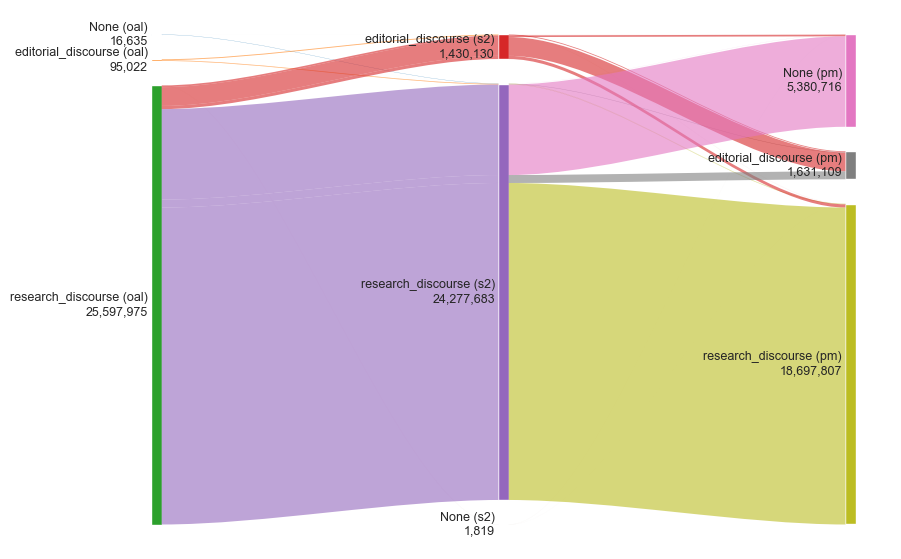

In [124]:
flows_df = s2_oal_pm_doctypes[['oal_new_type', 's2_new_type', 'pm_new_type', 'n']]
flows_df = flows_df.groupby(['oal_new_type', 's2_new_type', 'pm_new_type'])['n'].sum().reset_index()

flows = []
for index, row in flows_df.iterrows():
    flows.append((row['oal_new_type'], row['s2_new_type'], row['n']))
    flows.append((row['s2_new_type'], row['pm_new_type'], row['n']))

plt.figure(figsize=(10, 7))

s = Sankey(flows=flows, 
           flow_color_mode='lesser', 
           node_pad_y_min=0.05, 
           node_pad_y_max=0.12,
           node_opts=dict(label_opts=dict(fontsize=9)))
s.draw()
plt.show()